In [39]:
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
plt.rcParams['figure.figsize'] = (18,5)
import pickle
import plotly.express as px
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from joblib import dump, load
import traceback

import warnings
warnings.filterwarnings('ignore')




# Diabetes Dataset from Kaggle

## Problem Statement

1. **You are diabetic**: This is a direct classification result when the probability of the diabetic class is above a certain threshold, often 0.5 for binary classification. However, this threshold can be adjusted based on the specific needs of the model and the business or medical requirements.

2. **You are not Diabetic**: Similarly, this is another direct classification result when the probability of the non-diabetic class is above the threshold.

3. **You have x% risk to become diabetic**: This is essentially the probability value assigned by the model to the diabetic class for the given entry. For instance, if you input a patient's data into the model and it outputs a probability of 0.65 for the "diabetic" class, it can be interpreted as "This patient has a 65% risk of becoming diabetic."

**Using Selected/Best Model with Probabilities:**

Using the model to predict class probabilities using the `predict_proba` method. This will provide probabilities for each class, and in the context of a binary problem like yours, the output will have two columns: the first column represents the probability of the "non-diabetic" class, and the second represents the probability of the "diabetic" class.

**to utilize models to analyze diabetes and non diabetes patients to find out what are the leading causes for diabetes**


## Features Being Used

Certainly! Here's a brief description of each feature:

1. **gender**: 
    - Represents the biological sex of the individual.
    - Typically categorized as "male," "female," or in some datasets, "other" or "non-binary."

2. **age**: 
    - Represents the age of the individual, usually measured in years.
    - Can be a continuous variable (e.g., 25.5 years) or discrete (e.g., 25 years).

3. **hypertension**: 
    - Indicates whether the individual has hypertension (high blood pressure).
    - It's usually a binary indicator: "yes" (or 1) for those with hypertension, and "no" (or 0) for those without.

4. **heart_disease**: 
    - Indicates whether the individual has any heart-related diseases.
    - Typically a binary feature: "yes" (or 1) for those with heart disease and "no" (or 0) for those without.

5. **smoking_history**: 
    - Describes the individual's history with smoking.
    - Can be categorical, with values such as "never smoked," "formerly smoked," "currently smoking," etc.

6. **bmi**: 
    - Stands for "Body Mass Index."
    - A measure used to determine whether a person has a healthy body weight for their height.
    - Calculated as weight in kilograms divided by the square of height in meters. 
    - Used as an indicator of underweight, normal weight, overweight, or obesity.

7. **HbA1c_level**: 
    - Refers to the Hemoglobin A1c test.
    - Measures the average blood sugar (glucose) level over the past 2-3 months.
    - Used to diagnose diabetes and gauge how well someone is managing their diabetes.
    - Values are often presented as a percentage. A higher percentage can indicate higher blood glucose levels.

8. **blood_glucose_level**: 
    - Represents the concentration of glucose present in the blood.
    - Measured in milligrams per deciliter (mg/dL) or millimoles per liter (mmol/L).
    - A key indicator for diagnosing and monitoring diabetes.

Each of these features provides valuable health-related information. In the context of predicting or understanding diabetes, they are all relevant as they are associated with risk factors or direct indicators of diabetes.

In [40]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [41]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


## 1.1 EDA 

### 1.1.0 Corrolation Matrix

In [42]:
corr = df.select_dtypes(["int64", "float64"]).corr()
corr

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


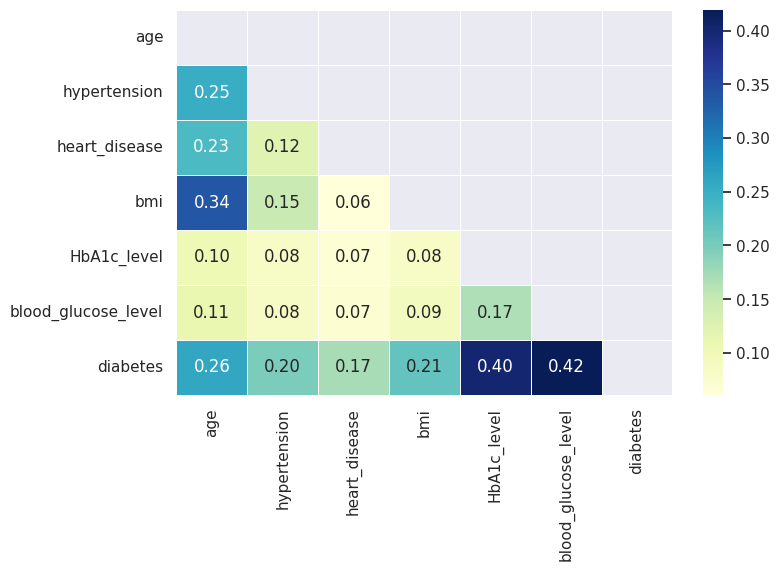

In [43]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask
plt.figure(figsize=(8, 5))
sns.heatmap(corr, mask=mask, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.show()

> **Above Corrolation Heatmap indicates Hemoglobin A1c, Blood Glucose Level and Age are highly corrolated with Diabetes, compared to other features**


### 1.1.1 Age Univariate

In [44]:
df.age.describe()

count    100000.000000
mean         41.885856
std          22.516840
min           0.080000
25%          24.000000
50%          43.000000
75%          60.000000
max          80.000000
Name: age, dtype: float64


The average age across all the entries is approximately 41.79 years.

3. **std**: The standard deviation, which is a measure of the amount of variation or dispersion in the set of values, is approximately 22.46 years. This suggests that most of the ages lie within 22.46 years above or below the mean age (41.79 years).

4. **min**: The youngest age in the dataset is 0.08 years, which is likely a baby of about a month old (around 29 days).

5. **25% (First Quartile)**: 25% of the people in the dataset are younger than 24 years. This is the age below which a quarter of the data falls.

6. **50% (Median)**: The median age, or the age at which half of the data points are above and half are below, is 43 years.

7. **75% (Third Quartile)**: 75% of the people in the dataset are younger than 59 years. This means that three-quarters of the data falls below this age, and one-quarter of the data is above it.

8. **max**: The oldest age in the dataset is 80 years.


### Gender Analysis Univariate and Bivariate 

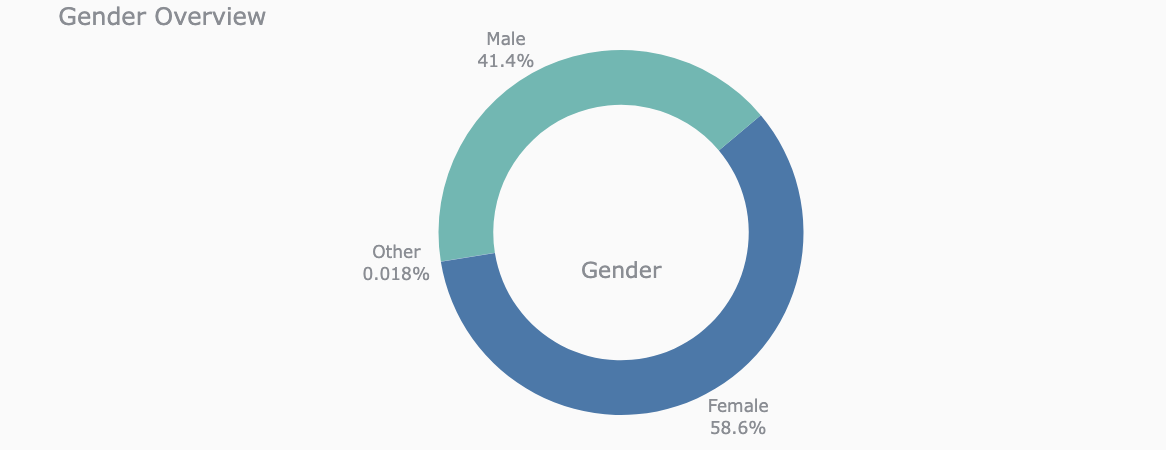

In [45]:
gender_count = df["gender"].value_counts().to_frame()

fig = px.pie(df, names='gender', height=450, width=1200, hole=0.7, 
                   color_discrete_sequence=['#4c78a8', '#72b7b2', '#6b92bc'], title="Gender Overview")
fig.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=50)
fig.update_layout(margin=dict(t=50, b=35, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))

fig.add_annotation(dict(x=0.5, y=0.4,  align='center',
                        xref = "paper", yref = "paper",
                        showarrow = False, font_size=22,
                        text="Gender"))

fig.add_layout_image(
    dict(
        source="https://i.imgur.com/3Cab96Z.jpg",
        xref="paper", yref="paper",
        x=0.48, y=0.48,
        sizex=0.3, sizey=0.25,
        xanchor="right", yanchor="bottom", sizing= "contain",
    )
)
fig.add_layout_image(
    dict(
        source="https://i.imgur.com/c6QKoDy.jpg",
        xref="paper", yref="paper",
        x=0.55, y=0.48,
        sizex=0.3, sizey=0.25,
        xanchor="right", yanchor="bottom", sizing= "contain",
    )
)


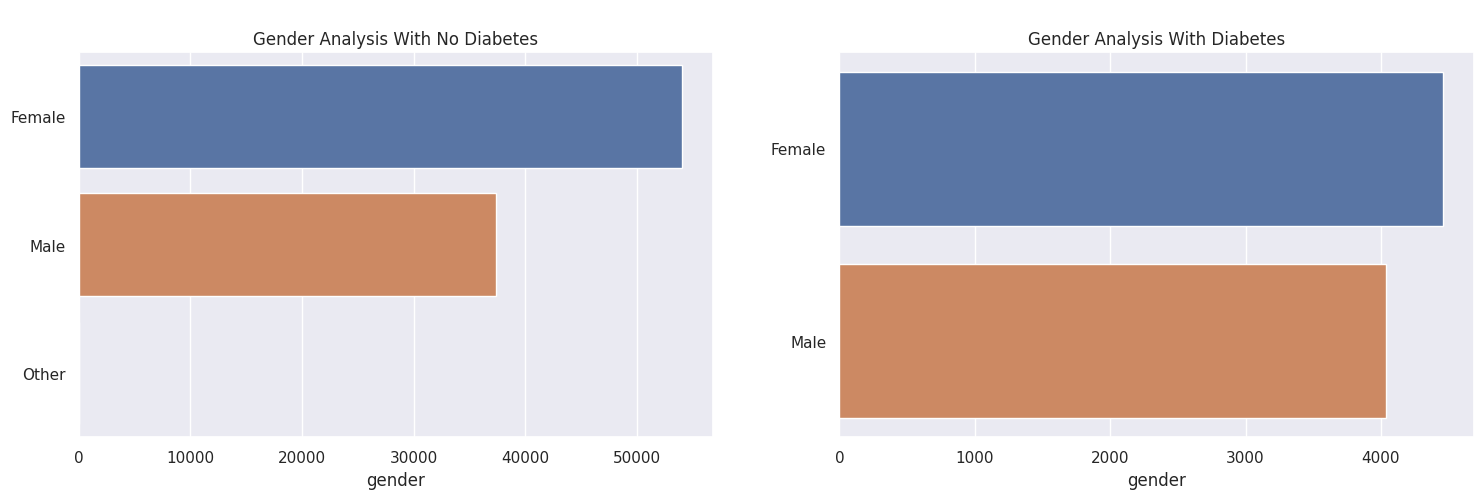

In [46]:
gender_count_no_diabetes = df.query("diabetes == 0")["gender"].value_counts().to_frame()
gender_count_diabetes = df.query("diabetes == 1")["gender"].value_counts().to_frame()


fig, ax = plt.subplots(nrows=1, ncols=2)


fig1 = sns.barplot(data=gender_count_no_diabetes, y=gender_count_no_diabetes.index, x="gender", ax=ax[0]);
fig1.set_title("\nGender Analysis With No Diabetes");

fig2 = sns.barplot(data=gender_count_diabetes, y=gender_count_diabetes.index, x="gender", ax=ax[1]);
fig2.set_title("\nGender Analysis With Diabetes");


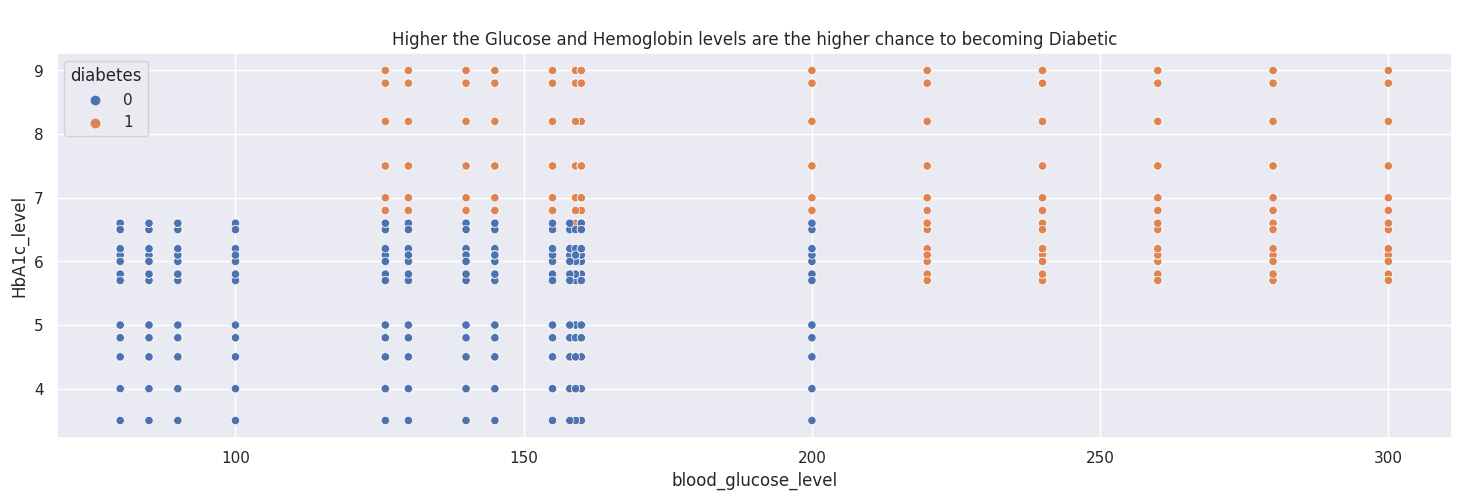

In [47]:
fig = sns.scatterplot(data=df,y="HbA1c_level", x="blood_glucose_level", hue="diabetes");
fig.set_title("\nHigher the Glucose and Hemoglobin levels are the higher chance to becoming Diabetic");


### 1.1.2 Age Bivariate With Diabetes

In [48]:
diabete_age = df.groupby("diabetes")[["age"]].mean()

diabete_age.head()

,age
diabetes,
0,40.115187
1,60.946588


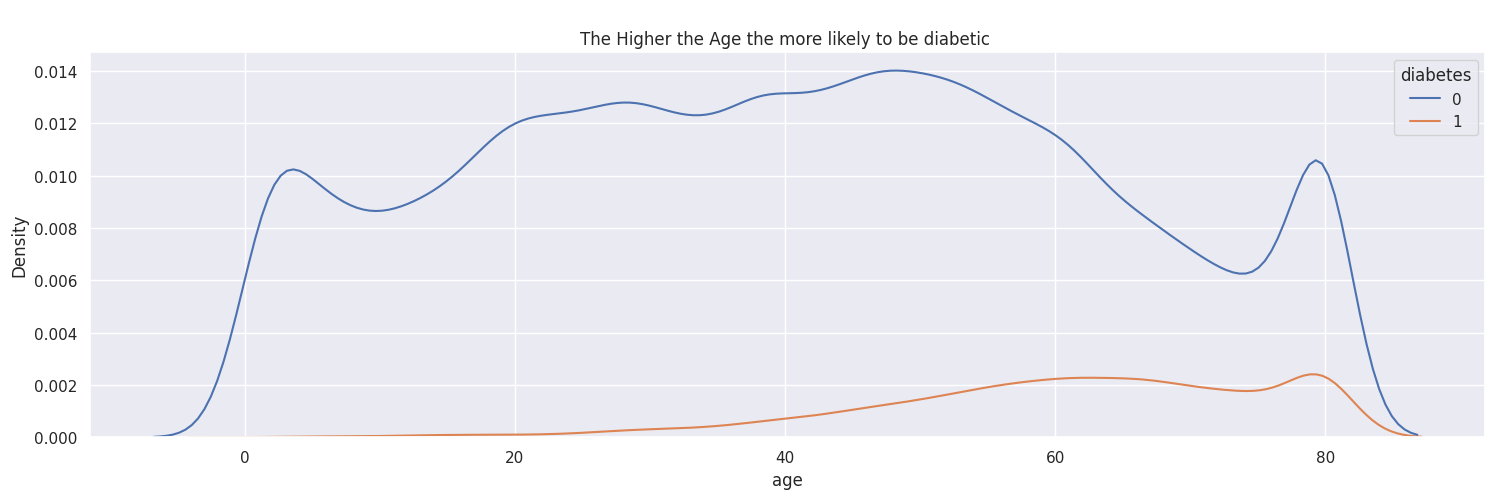

In [49]:
sns.kdeplot(df, x="age", hue="diabetes");
plt.title("\nThe Higher the Age the more likely to be diabetic ");

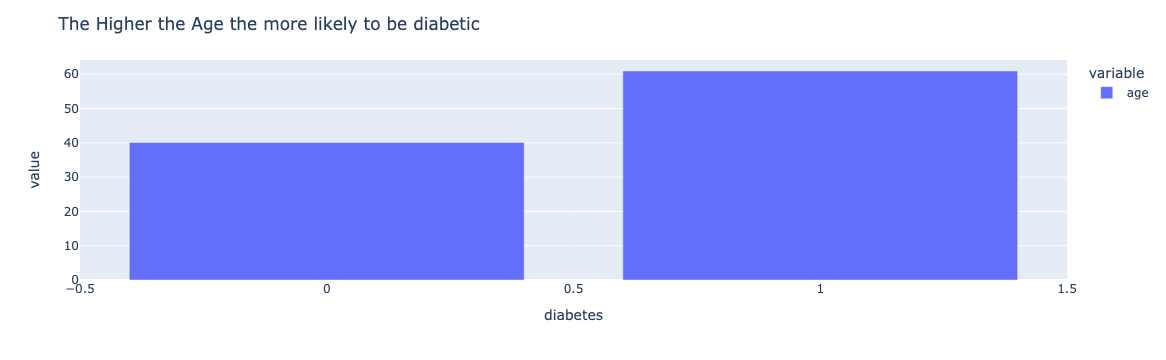

In [50]:
fig = px.bar(diabete_age)

fig.update_layout(title_text="The Higher the Age the more likely to be diabetic")


### 1.1.3 Hemoglobin A1c Level Bivariate with Diabetes 

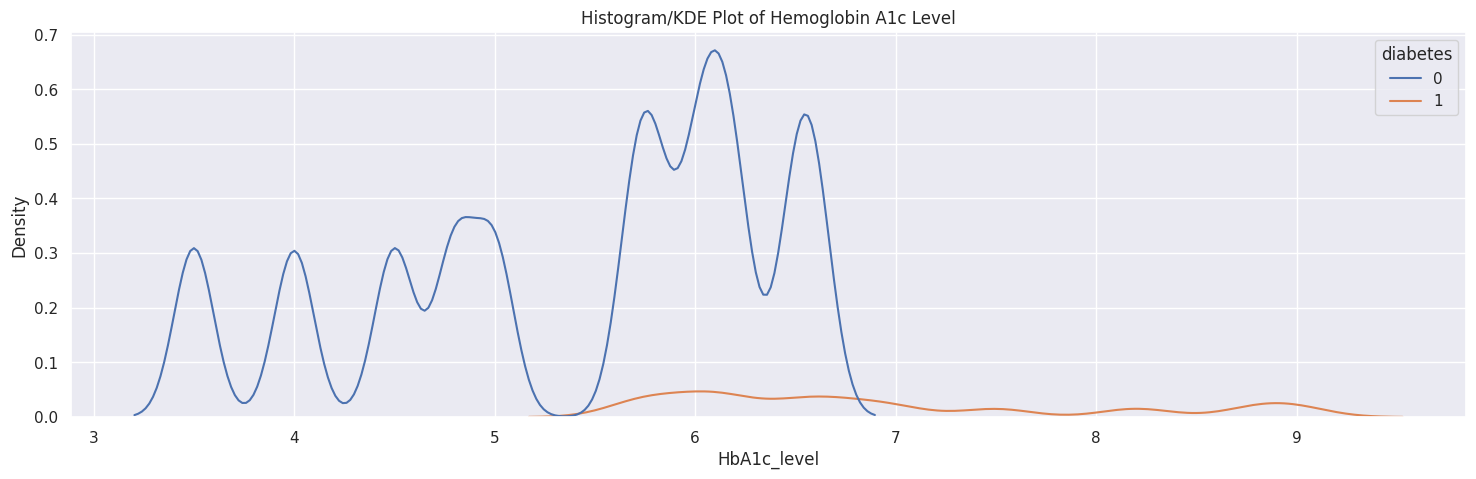

In [51]:
fig = sns.kdeplot(df, x="HbA1c_level", hue="diabetes");
fig.set_title("Histogram/KDE Plot of Hemoglobin A1c Level");

# do side by side for Diabetes and Non Diabetes 

#### T-Test and Finding the Confidence Interval For HbA1c_Level For both Groups of Diabetes and Non-Diabetes 

The results suggest a very strong statistical difference between the two groups:

- **t-statistic**: The t-statistic of approximately 138.28 is very high, which suggests a large difference in the means of the two groups relative to the variability within the groups.

- **p-value**: A p-value of 0.0 is indicative of the results being extremely statistically significant. This means that the likelihood of observing such extreme differences in "HbA1c_level" between the two groups (one with "diabetes" equal to 1 and the other with "diabetes" equal to 0) purely by chance is virtually zero.

Given these results, you would reject the null hypothesis, which assumes that there's no difference between the two groups. This indicates that there is a statistically significant difference in "HbA1c_level" between the group with "diabetes" equal to 1 and the group with "diabetes" equal to 0.

However, always remember that statistical significance does not necessarily mean clinical or practical significance. While the t-test tells you if the means of the two groups are different, it doesn't tell you how meaningful that difference is in real-world terms. You might also want to look at confidence intervals, effect size, and other measures to better understand the significance of these results.

The confidence interval you've calculated suggests that if the underlying population from which your samples are drawn were subject to many additional samples, approximately 95% of those calculated intervals would contain the true difference in means between the two populations.

In your specific example, the 95% confidence interval for the difference in mean HbA1c levels between the two groups (one with diabetes and one without) is \([1.5145, 1.5619]\).

What this means is that you can be 95% confident that the true difference in average HbA1c levels between people with diabetes and people without diabetes in the overall population will fall within this range.

Given the p-value of \(0.0\) in your t-test and this confidence interval that doesn't contain zero, it's safe to say that the difference in means is statistically significant. Therefore, you have strong evidence to conclude that the average HbA1c levels are indeed different between the two groups.

In [57]:
import scipy.stats

Hba_diabetes = df.query("diabetes == 1")["HbA1c_level"]
Hba_no_diabetes = df.query("diabetes == 0")["HbA1c_level"]


t_statistic, p_value = scipy.stats.ttest_ind(Hba_diabetes, Hba_no_diabetes, equal_var=True)

print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 138.28308350581383
p-value: 0.0


In [58]:
import numpy as np
import scipy.stats

# Assume heights_group1 and heights_group2 are your data
mean1, mean2 = np.mean(Hba_diabetes), np.mean(Hba_no_diabetes)
std1, std2 = np.std(Hba_diabetes, ddof=1), np.std(Hba_no_diabetes, ddof=1)  # ddof=1 for sample standard deviation
n1, n2 = len(Hba_diabetes), len(Hba_no_diabetes)

# Calculate the standard error of the difference in means
std_err_difference = np.sqrt((std1**2 / n1) + (std2**2 / n2))

# Find the t-critical value for a 95% confidence interval
alpha = 0.05  # for a 95% confidence interval
degree_freedom = min(n1, n2) - 1  # degrees of freedom
t_critical = scipy.stats.t.ppf(1 - alpha / 2., degree_freedom)

# Calculate the margin of error
margin_of_error = t_critical * std_err_difference

# Calculate the confidence interval
conf_interval_lower = mean1 - mean2 - margin_of_error
conf_interval_upper = mean1 - mean2 + margin_of_error

print("Confidence interval:", [conf_interval_lower, conf_interval_upper])


Confidence interval: [1.5144523771034657, 1.5619321937740636]


In [59]:
hba_diab_count = df.groupby("diabetes")[["HbA1c_level"]].mean()

hba_diab_count.index = np.where(hba_diab_count.index == 0, "No Diabetes", "Diabetes")

hba_diab_count.round(2)

,HbA1c_level
No Diabetes,5.40
Diabetes,6.93


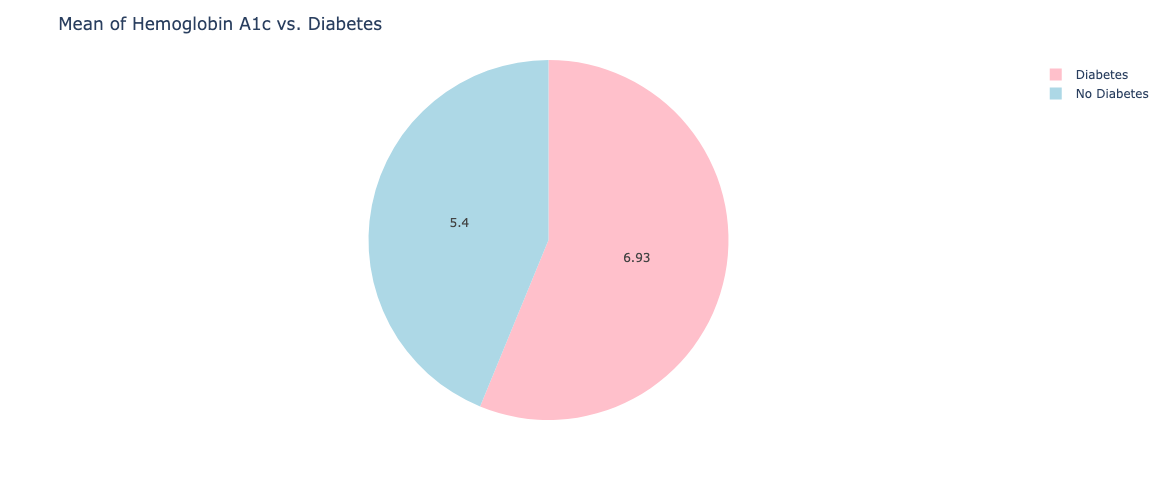

In [56]:
fig = px.pie(hba_diab_count.round(2), values="HbA1c_level", names=hba_diab_count.index, color_discrete_sequence=["pink", "lightblue"])
fig.update_layout(width=500, height=500, title_text="Mean of Hemoglobin A1c vs. Diabetes")
fig.update_traces(textposition='inside', textinfo='value')


### 1.1.4 Blood Glucose Level Bivariate With Diabetes 

#### T-Test and Finding the Confidence Interval For Blood Glucose Level For both Groups of Diabetes and Non-Diabetes 

**Testing whether the mean blood glucose level differs between people with diabetes (`bg_diabetes`) and those without diabetes (`bg_no_diabetes`).**

### t-statistic:

The t-statistic is a measure of how many standard errors the sample means of the two groups are apart. A larger absolute value of the t-statistic indicates that the difference between the means is more significant.

- **t-statistic: 146.16**: The t-statistic is very high, indicating that the means of blood glucose levels in the two groups are significantly different from each other.

### p-value:

The p-value is a measure of the evidence against the null hypothesis, which in this case is that there's no difference between the two groups.

- **p-value: 0.0**: A p-value of 0.0 means that the likelihood of observing such extreme differences between the groups under the assumption that they are the same (the null hypothesis) is virtually zero. 

### Summary:

Given the high t-statistic and the p-value of nearly zero, we can confidently reject the null hypothesis. This means that there is a statistically significant difference in the mean blood glucose levels between people with diabetes and those without diabetes in your dataset.

You would generally proceed to examine the means of each group to determine the direction of this difference (i.e., whether people with diabetes have higher or lower blood glucose levels compared to those without diabetes).

In [68]:
import scipy.stats

bg_diabetes = df.query("diabetes == 1")["blood_glucose_level"]
bg_no_diabetes = df.query("diabetes == 0")["blood_glucose_level"]


t_statistic, p_value = scipy.stats.ttest_ind(bg_diabetes, bg_no_diabetes, equal_var=True)
print()
print("-"*50)
print('t-statistic:', round(t_statistic, 2))
print('p-value:', p_value)
print("-"*50)
print()


--------------------------------------------------
t-statistic: 146.16
p-value: 0.0
--------------------------------------------------



In [70]:
import numpy as np
import scipy.stats

# Assume heights_group1 and heights_group2 are your data
mean1, mean2 = np.mean(bg_diabetes), np.mean(bg_no_diabetes)
std1, std2 = np.std(bg_diabetes, ddof=1), np.std(bg_no_diabetes, ddof=1)  # ddof=1 for sample standard deviation
n1, n2 = len(bg_diabetes), len(bg_no_diabetes)

# Calculate the standard error of the difference in means
std_err_difference = np.sqrt((std1**2 / n1) + (std2**2 / n2))

# Find the t-critical value for a 95% confidence interval
alpha = 0.05  # for a 95% confidence interval
degree_freedom = min(n1, n2) - 1  # degrees of freedom
t_critical = scipy.stats.t.ppf(1 - alpha / 2., degree_freedom)

# Calculate the margin of error
margin_of_error = t_critical * std_err_difference

# Calculate the confidence interval
conf_interval_lower = mean1 - mean2 - margin_of_error
conf_interval_upper = mean1 - mean2 + margin_of_error
print()
print("-"*50)
print("Confidence interval:", [round(conf_interval_lower, 2), round(conf_interval_upper, 2)])
print("-"*50)
print()



--------------------------------------------------
Confidence interval: [59.98, 62.51]
--------------------------------------------------



In [71]:
glc_diab_count = df.groupby("diabetes")[["blood_glucose_level"]].mean()

glc_diab_count.index = np.where(glc_diab_count.index == 0, "No Diabetes", "Diabetes")

glc_diab_count.round(2)

,blood_glucose_level
No Diabetes,132.85
Diabetes,194.09


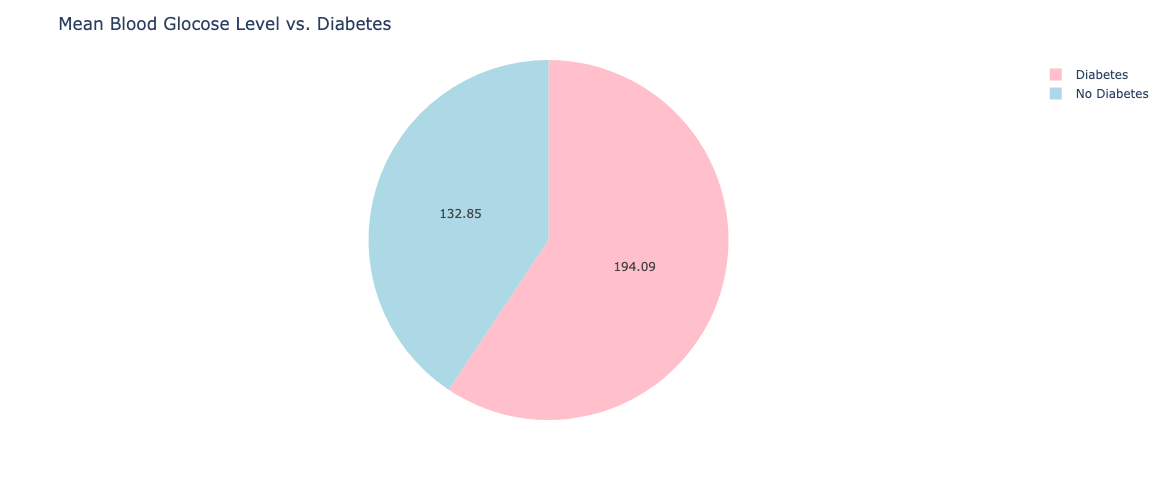

In [72]:
fig = px.pie(glc_diab_count.round(2), values="blood_glucose_level", names=glc_diab_count.index, color_discrete_sequence=["pink", "lightblue"])
fig.update_layout(width=500, height=500, title_text="Mean Blood Glocose Level vs. Diabetes")
fig.update_traces(textposition='inside', textinfo='value')



## 1.2 Data Preproccesing 

In [ ]:
# checking how balance the Data is 


df.diabetes.value_counts(normalize=True)

**As shown above, the dataset is highly imbalanced**

In [ ]:
# Checking the duplicates

df.duplicated().value_counts()

In [ ]:
# Dropping the Duplicates

df.drop_duplicates(inplace=True)

### 1.2.1 Replacing No Info in smoking_histroy to NaN and we will Impute them with `most_frequent`

<p style="font-size:30px; color:red">In Medical Data Imputing is not recommended </p>

In [ ]:
df["smoking_history"] = df["smoking_history"].replace("No Info", np.nan)

In [ ]:
df.head(2)

In [ ]:
df.isnull().sum()

### 1.2.2 Imputing the NaNs with `most_frequent`

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")

smoking_imputed = imputer.fit_transform(df[["smoking_history"]])
df.smoking_history = smoking_imputed
df.isnull().sum()

## 1.3 Models

1. **LogisticRegression** 
2. **LogisticRegression** 
3. **DecisionTreeClassifier** 
4. **DecisionTreeClassifier** with `roc_auc` Scoring
5. **RandomForest** 
6. **XGBoost**


In [ ]:
X = df.drop(columns="diabetes")
y = df["diabetes"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

### 1.3.1 Creating Dummy Model For Bench Mark

In [ ]:
dummy = DummyClassifier()

In [ ]:
dummy.fit(X_train, y_train)

# accuracy score
print("The accuracy of the dummy classifier for train is {:.2%}".format(dummy.score(X_train, y_train)))
print("The accuracy of the dummy classifier for test is {:.2%}".format(dummy.score(X_test, y_test)))

>> Based what we saw above 91.5% of the data in one class and the rests are in another class.

### 1.3.2 Model's Grid Hyperparameters

In [ ]:
# Decision Tree Hyperparameters
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': [None, 10, 20, 30, 40, 50],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10],
    'dt__max_features': [None, 'sqrt', 'log2'],
}
dt_param_grid_base = {
    'dt__base_model__criterion': ['gini', 'entropy'],
    'dt__base_model__splitter': ['best', 'random'],
    'dt__base_model__max_depth': [None, 10, 20, 30, 40, 50],
    'dt__base_model__min_samples_split': [2, 5, 10, 20],
    'dt__base_model__min_samples_leaf': [1, 2, 5, 10],
    'dt__base_model__max_features': [None, 'sqrt', 'log2'],
}


# RandomForest Hyperparameters 
rfc_param_grid_base = {
    'rfc__base_model__n_estimators': np.arange(10, 200, 10),
    'rfc__base_model__max_features': ['sqrt'],
    'rfc__base_model__max_depth': np.arange(1, 20),
    'rfc__base_model__bootstrap': [True, False],
    'rfc__base_model__criterion': ['gini', 'entropy'],
    # 'rfc__min_samples_split': [2, 5, 10],
    # 'rfc__min_samples_leaf': [1, 2, 4],
}

# RandomForest Hyperparameters 
rfc_param_grid = {
    'rfc__n_estimators': np.arange(10, 200, 10),
    'rfc__max_features': ['sqrt'],
    'rfc__max_depth': np.arange(1, 20),
    'rfc__bootstrap': [True, False],
    'rfc__criterion': ['gini', 'entropy'],
    # 'rfc__min_samples_split': [2, 5, 10],
    # 'rfc__min_samples_leaf': [1, 2, 4],
}

# Support Vector Mechine Hyperparameters
svc_param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    # 'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    # 'svc__degree': [2, 3, 4, 5],  # Only used when kernel is 'poly'
    # 'svc__coef0': [0, 1, 2, 3],  # Useful for 'poly' and 'sigmoid'
    # 'svc__shrinking': [True, False],
}

# LogistcRegression Hyperparameters
lgr_param_grid = {
    'lgr__C': [100, 10, 1.0, 0.1, 0.01],
    'lgr__solver': ['newton-cg', 'lbfgs', 'saga', 'sag'],
    'lgr__penalty': ['l2']
}

lgr_param_grid_base = {
    'lgr__base_model__C': [100, 10, 1.0, 0.1, 0.01],
    'lgr__base_model__solver': ['newton-cg', 'lbfgs', 'saga', 'sag'],
    'lgr__base_model__penalty': ['l2']
}


xgb_param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [4, 5, 6],
    # 'xgb__min_child_weight': [1, 2, 3],
    # 'xgb__gamma': [0, 0.1, 0.2],
    # 'xgb__subsample': [0.8, 0.9, 1.0],
    # 'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__objective': ['binary:logistic']
}



xgbrf_param_grid = {
    'xgbrf__n_estimators': [100, 200, 300],  # Number of boosted trees to fit
    'xgbrf__max_depth': [3, 5, 7, 10],       # Maximum tree depth for base learners
    'xgbrf__learning_rate': [0.01, 0.05, 0.1], # Boosting learning rate (xgb's "eta")
    # 'xgbrf__subsample': [0.7, 0.8, 0.9, 1], # Subsample ratio of the training instance
    # 'xgbrf__colsample_bytree': [0.7, 0.8, 0.9, 1],  # Subsample ratio of columns when constructing each tree
    # 'xgbrf__min_child_weight': [1, 2, 3],   # Minimum sum of instance weight(hessian) needed in a child
    # 'xgbrf__gamma': [0, 0.1, 0.2],           # Minimum loss reduction required to make a further partition
    # 'xgbrf__scale_pos_weight': [0.5, 1, 2],  # Balancing of positive and negative weights
    # 'xgbrf__reg_alpha': [0, 0.1, 0.5],       # L1 regularization term on weights
    # 'xgbrf__reg_lambda': [1, 1.5, 2]        # L2 regularization term on weights
}


adaboost_params = {
    'ada__n_estimators': [10, 50, 100, 200],
    'ada__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

gradientboost_params = {
    'grb__n_estimators': [10, 50, 100, 200],
    'grb__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    # 'grb__subsample': [0.5, 0.8, 1.0],
    'grb__max_depth': [3, 4, 5, 6, 7],
    # 'grb__min_samples_split': [2, 3, 4],
    # 'grb__min_samples_leaf': [1, 2, 3]
}

gaussiannb_params = {
    'gnb__var_smoothing': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
}

### 1.3.3 Column Transformers, Pipeline and GridSearchCV 

* Standardizing the `"age", "bmi", "HbA1c_level", "blood_glucose_level"`
* Applying PolynomialFeatures to the Standardized Columns 
* Applying OneHotEncoding to `"gender"`
* Since this dataset is highly imbalaced, Using `SMOTE` technique to create a balanced class on training dataset. (This technique will increase the number of minority classes)
* Applying the above the GridSearchCV with 5 Cross Validation with `f1` and `roc-auc` Scoring 
    * Using F1 Scoring since we want a mean of both False Negative and False Positive 

In [ ]:
from sklearn.base import BaseEstimator

# creating a class which can change the probability threshold during the fit
class ThresholdAdjuster(BaseEstimator):
    def __init__(self, base_model=None, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        probabilities = self.base_model.predict_proba(X)
        return (probabilities[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

    def decision_function(self, X):
        return self.base_model.decision_function(X)

In [ ]:
    
poly_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ("poly", PolynomialFeatures(include_bias=False, degree=3))
])

no_poly_pipe = Pipeline([
    ('scaler', StandardScaler()), 
])


col_transformer_poly = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary"), ["gender", "smoking_history"]),
    ('poly_pipe', poly_pipe, ["age", "bmi", "HbA1c_level", "blood_glucose_level"])
])


# col_transformer_no_poly = ColumnTransformer(transformers=[
#     ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary"), ["gender", "smoking_history"]),
#     ('poly_pipe', no_poly_pipe, ["age", "bmi", "HbA1c_level", "blood_glucose_level"])
# ])


def randomized_search_(scoring, param_grid, name_step, model, optimal_threshold=0.5, adj=True, poly=True):
    adjusted_model = ThresholdAdjuster(model, threshold=optimal_threshold)
    pipe = ""
    if not adj and not poly:
        pipe = Pipeline([
            ("transformer", col_transformer_no_poly),
            ('smote', SMOTE(random_state=42)),
            (name_step, model)
        ])
        
    elif not adj and poly:
        pipe = Pipeline([
            ("transformer", col_transformer_poly),
            ('smote', SMOTE(random_state=42)),
            (name_step, model)
        ])
        
    elif adj and not poly:
        pipe = Pipeline([
            ("transformer", col_transformer_no_poly),
            ('smote', SMOTE(random_state=42)),
            (name_step, adjusted_model)
        ])
        
    elif adj and poly:
        pipe = Pipeline([
            ("transformer", col_transformer_poly),
            ('smote', SMOTE(random_state=42)),
            (name_step, adjusted_model)
        ])
        
        
    return GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)



def randomized_search(scoring, param_grid, name_step, model):
    pipe = Pipeline([
        ("transformer", col_transformer_poly),
        ('smote', SMOTE(random_state=42)),
        (name_step, model)
    ])   
    return GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)



In [ ]:


models = [
#     {"lgr_model": randomized_search("recall", lgr_param_grid, "lgr", LogisticRegression(max_iter=200000))},
    
#     {"dt_model": randomized_search("recall", dt_param_grid, "dt", DecisionTreeClassifier())},
    
    # {"rfc_model": randomized_search("recall", rfc_param_grid, "rfc", RandomForestClassifier())},
    
#     {"xgb_model": randomized_search("recall", xgb_param_grid, "xgb", xgb.XGBClassifier(eval_metric="error"))},
    
#     {"xgbrf_model": randomized_search("recall", xgbrf_param_grid, "xgbrf", xgb.XGBRFClassifier())},
    
    # {"ada_model": randomized_search("recall", adaboost_params, "ada", AdaBoostClassifier())},
    
    {"grb_model": randomized_search("recall", gradientboost_params, "grb", GradientBoostingClassifier())},
    
    {"gnb_model": randomized_search("recall", gaussiannb_params, "gnb", GaussianNB())},

]

        

### Plotting Recall and Percision

In [ ]:
def precision_thresh(predict_probs, y, thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    return precision_score(y, preds, pos_label=1)

def recall_thresh(predict_probs, y, thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    return recall_score(y, preds, pos_label=1)


def plot_recall_precision(Xtest, ytest, model, title):
    prob_table = model.predict_proba(Xtest)[:, 1]
    thresholds = np.arange(0, 1, .05)
    results_df = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh(prob_table, ytest, i) for i in thresholds]})
    results_df['recall'] = [recall_thresh(prob_table, ytest, i) for i in thresholds]
    
    plt.figure(figsize=(14, 5))
    plt.plot(results_df['threshold'], results_df['precision'], '--o', label='Precision')
    
    plt.plot(results_df['threshold'], results_df['recall'], '--o', label='Recall', lw=2)
    plt.legend()
    plt.xticks(thresholds)
    plt.xlabel('Threshold')
    plt.ylabel('Precision and Recall')
    plt.title(title)
    plt.grid();

In [ ]:
for i in models:
    try:
        for model_name, model in i.items():
            model = model.fit(X_train, y_train)
            filename = f'models/new_models/{model_name}.sav'
            dump(model, filename)
    except Exception:
        traceback.print_exc()
        pass

In [ ]:
import os
files = os.listdir("models/new_models")


models_dict = {}
for file in files:
    key = file.strip().split(".")[0]
    if key:
        model = load(f"models/new_models/{file}")
        models_dict[key] = model


## Trying the Ensemble or Meta Model with LogisticRegression as Final Estimator

In [ ]:
model_keys = list(models_dict.keys())

In [ ]:
models_dict["xgbrf_model"]

In [ ]:
lgr_model = models_dict["lgr_model"]

rfc_model = models_dict["rfc_model"]
dt_model = models_dict["dt_model"]

xgbrf_model = models_dict["xgbrf_model"]
xgb_model = models_dict["xgb_model"]
ada_model = models_dict["ada_model"]
grb_model = models_dict["grb_model"]
gnb_model = models_dict["gnb_model"]


In [ ]:
model_list = [
    ("lgr_model", lgr_model),
    ("rfc_model", rfc_model),
    ("dt_model", dt_model),
    ("xgb_model", xgb_model),
    ("xgbrf_model", xgbrf_model),
]

In [ ]:
stacked_model = StackingClassifier(
    estimators=model_list, final_estimator=LogisticRegression()
)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Assume X_train, y_train are your training data and target respectively.
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Storage for out-of-fold predictions
meta_features = np.zeros((X_train.shape[0], len(model_list)))

# Generating out-of-fold predictions
for train_idx, valid_idx in kfold.split(X_train, y_train):
    fold_X_train, fold_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    
    # Use fold_X_train and fold_X_valid to generate out-of-fold predictions
    for i, (_, model) in enumerate(model_list):
        # Here, assuming the model has a predict_proba method. Otherwise, adapt accordingly
        preds = model.predict_proba(fold_X_valid)[:, 1]
        meta_features[valid_idx, i] = preds

# Now, meta_features contains the out-of-fold predictions which can be used as features for the meta-model

# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train)

# For future predictions, take predictions from all base models and feed as input to the meta_model:
# e.g., meta_model.predict(np.column_stack([model1.predict(X_new), model2.predict(X_new), model3.predict(X_new)]))


In [ ]:
def meta_predict(new_X):
    meta_preds = meta_model.predict(
        np.column_stack(
            [
                rfc_model.predict(X_test), 
                dt_model.predict(X_test), 
                xgb_model.predict(X_test),
                lgr_model.predict(X_test), 
                xgbrf_model.predict(X_test), 
            ]))
    return meta_preds


In [ ]:
meta_preds = meta_predict(X_test)

In [ ]:
rfc_preds = models_dict["rfc_model"].predict(X_test)

dt_preds = models_dict["dt_model"].predict(X_test)

lgr_preds = models_dict["lgr_model"].predict(X_test)

xgbrf_preds = xgbrf_model.predict(X_test)

xgb_preds = xgb_model.predict(X_test)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))



ConfusionMatrixDisplay.from_predictions(
    y_test, 
    lgr_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[0, 0]
)


ConfusionMatrixDisplay.from_predictions(
    y_test, 
    rfc_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[0, 1]
)

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    dt_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[0, 2]
)


ConfusionMatrixDisplay.from_predictions(
    y_test, 
    xgb_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[1, 0]
)

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    xgbrf_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[1, 1]
)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    meta_preds, 
    # display_labels=["No Diabetes", "Diabetes"], 
    ax=ax[1, 2]
)




ax[0, 0].set_title("LogisticRegression");
ax[0, 1].set_title("RandomForestClassifier");
ax[0, 2].set_title("DecisionTree");

ax[1, 0].set_title("XGBoost");
ax[1, 1].set_title("XGBoostRandomForest Classifier");
ax[1, 2].set_title("Meta Preds with 5 Models");


fig.suptitle('Confusion Matrix Comparison');

In [ ]:
plot_recall_precision(X_test, y_test, xgb_model, "\n\nXGBoost Precision vs. Recall")
plot_recall_precision(X_test, y_test, xgbrf_model, "\n\nXGBoostRandomForest Precision vs. Recall")
plot_recall_precision(X_test, y_test, models_dict["lgr_model"], "\n\nLogisticRegression Precision vs. Recall")
plot_recall_precision(X_test, y_test, models_dict["rfc_model"], "\n\nRandomForest Precision vs. Recall")
plot_recall_precision(X_test, y_test, models_dict["dt_model"], "\n\nDecisionTree Precision vs. Recall")


In [38]:
plot_recall_precision(X_test, y_test, grb_model, "GRB")

NameError: name 'plot_recall_precision' is not defined

In [ ]:
grb_test_pred = grb_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    grb_test_pred,
    display_labels=["No Diabetes", "Diabetes"], 
)

In [ ]:
plot_recall_precision(X_test, y_test, gnb_model, "GNB")

In [ ]:
gnb_test_pred = gnb_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    gnb_test_pred,
    display_labels=["No Diabetes", "Diabetes"], 
)

In [ ]:
plot_recall_precision(X_test, y_test, ada_model, "AdaBoost")

In [ ]:
ada_test_pred = ada_model.predict(X_test)

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    ada_test_pred,
    display_labels=["No Diabetes", "Diabetes"], 
)



1. **Class Imbalance**: Your dataset is highly imbalanced with 91% belonging to class 0 and 9% to class 1. Handling class imbalances properly is crucial for a good model, especially for the minority class.

2. **True Positives (TP)**: Your model has been able to correctly predict 1717 out of 1721 positive samples, which is impressive.

3. **False Positives (FP)**: The model has predicted 5762 samples as positive which were actually negative. This is a significant number and could be a major concern depending on the context of the problem.

4. **True Negatives (TN)**: Out of the 17509 actual negatives, the model correctly predicted 11747 of them as negative.

5. **False Negatives (FN)**: Only 4 out of 1721 actual positives were predicted as negative. This is very low, which is good.

Now, let's compute some metrics:


<ul>
    <li>
        <strong>Precision</strong>: \( \frac{TP}{TP + FP} \) = \( \frac{1717}{1717 + 5762} \) ≈ 0.23
        <ul>
            <li>This means that out of all the samples the model predicted as positive, only 23% were actually positive.</li>
        </ul>
    </li>
    <br>
    <li>
        <strong>Recall (or Sensitivity)</strong>: \( \frac{TP}{TP + FN} \) = \( \frac{1717}{1717 + 4} \) ≈ 0.997
        <ul>
            <li>This indicates that the model captures almost all of the actual positive samples, which is great.</li>
        </ul>
    </li>
    <br>
    <li>
        <strong>Specificity</strong>: \( \frac{TN}{TN + FP} \) = \( \frac{11747}{11747 + 5762} \) ≈ 0.67
        <ul>
            <li>This tells us that the model correctly identified 67% of the actual negative samples.</li>
        </ul>
    </li>
    <br>
    <li>
        <strong>Accuracy</strong>: \( \frac{TP + TN}{TP + TN + FP + FN} \) ≈ 0.68
        <ul>
            <li>About 68% of all predictions made by the model are correct.</li>
        </ul>
    </li>
</ul>



Conclusions:

- Your model has high recall, meaning it's very good at capturing the positive class (class 1). This is also evident by the very low false negative count.
  
- However, the precision is low, which means among those predicted as positive, a significant number are actually negative. This is due to the high number of false positives.
  
- The adjusted threshold of 0.05 makes the model very sensitive to predicting positives. By reducing the threshold, you're making it easier to classify a sample as positive, which can increase recall but at the cost of precision.

- The use of PolynomialFeatures of degree 3 would have added complexity to the model, which might be capturing the non-linear patterns in the data well, but there's also a risk of overfitting.

What to do next?

1. **Business Context**: Depending on your application, you need to decide which metric is more important. For some applications, having a high recall might be critical even at the cost of precision. For others, too many false positives could be problematic.

2. **Experiment**: You might want to experiment by adjusting the threshold. Increasing it will likely decrease your false positives but may also decrease your true positives. It's a trade-off.

3. **Feature Importance**: Since it's a DecisionTreeClassifier, you can look at feature importance to understand which features are driving the decisions.

4. **Complexity**: You've introduced complexity with polynomial features. Try simpler models or reduce the polynomial degree and see if you can maintain high recall with better precision.

5. **Alternative Methods**: Consider other methods to handle class imbalance such as SMOTE, ADASYN, or using different algorithms known for handling imbalance better.

Remember, while metrics are valuable, they should always be interpreted in the context of the specific problem you're trying to solve.

### DecisionTreeClassifier Feature Importance

In [ ]:
dt_coefs = dt_model.best_estimator_.named_steps['dt'].feature_importances_


In [ ]:
# Get the pipeline and the column transformer
pipeline = dt_model.best_estimator_
transformer = pipeline.named_steps['transformer']
# Extract feature names for the one-hot encoder
ohe_transformer = transformer.named_transformers_['ohe']
ohe_features = list(ohe_transformer.get_feature_names_out(['gender', 'smoking_history']))

# Extract feature names for the polynomial features
poly_transformer = transformer.named_transformers_['poly_pipe']
poly_features = poly_transformer.named_steps['poly'].get_feature_names_out(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

# Combine the two lists
all_feature_names = ohe_features + list(poly_features)



In [ ]:
dt_feature_importance = pd.DataFrame({"coefs": dt_coefs, "features": all_feature_names})
dt_feature_importance.head()

In [ ]:
plt.figure(figsize=(18, 14))
sns.barplot(data=dt_feature_importance, y='features', x="coefs");
plt.xticks(rotation=90);

### LogisticRegression Feature Importance

In [ ]:
model = models_dict["lgr_model"]
lgr_coefs = model.best_estimator_.named_steps['lgr'].coef_
lgr_coefs = list(lgr_coefs[0])
model

In [ ]:
# Get the pipeline and the column transformer
pipeline = model.best_estimator_
transformer = pipeline.named_steps['transformer']

# Extract feature names for the one-hot encoder
ohe_transformer = transformer.named_transformers_['ohe']
ohe_features = list(ohe_transformer.get_feature_names_out(['gender', 'smoking_history']))

# Extract feature names for the polynomial features
poly_transformer = transformer.named_transformers_['poly_pipe']
print(poly_transformer)
poly_features = poly_transformer.named_steps['poly'].get_feature_names_out(["age",'bmi', 'HbA1c_level', 'blood_glucose_level'])

# Combine the two lists
all_feature_names = ohe_features + list(poly_features)



In [ ]:
lgr_feature_importance = pd.DataFrame({"coefs": lgr_coefs, "features": all_feature_names})
lgr_feature_importance.head()

In [ ]:
plt.figure(figsize=(18, 18))
sns.barplot(data=lgr_feature_importance, y='features', x="coefs");
plt.xticks(rotation=90);

In [ ]:
xgb_coefs = xgb_model.best_estimator_.named_steps["xgb"].feature_importances_

In [ ]:
a = xgb_model.best_estimator_.named_steps["transformer"]
b = a.named_transformers_['ohe']
b.get_

## Analyzing False Negatives 

In [ ]:
probas_0 = xgb_model.predict_proba(X_test)[:, 0]
probas_1 = xgb_model.predict_proba(X_test)[:, 1]


In [ ]:
new_X_test = X_test.copy()

In [ ]:
new_X_test["class_0"] = probas_0
new_X_test["class_1"] = probas_1
new_X_test["diabetes"] = y_test.copy()

In [ ]:
new_X_test.head()

<hr>

### False Negatives Predictions, Total of 158 

<hr>

In [ ]:
fn_preds = new_X_test.query("diabetes == 1 & class_0 > 0.5")
fn_preds.shape

In [ ]:
fn_preds.head()

In [ ]:
fig1 = sns.scatterplot(data=fn_preds, y="HbA1c_level", x="age")

# fig2 = sns.scatterplot(data=fn_preds, y="blood_glucose_level", x="age")


In [ ]:
tp_preds = new_X_test.query("diabetes == 1 & class_1 > 0.5")

In [ ]:
fig1 = sns.scatterplot(data=tp_preds, x="bmi", y="HbA1c_level")


## Testing the Model with Test Patient

In [ ]:
X_test.head()

In [ ]:
my_test = X_test.loc[2547, :].copy()

In [ ]:
my_test

In [ ]:
y_test[2547]

In [ ]:
my_test = pd.DataFrame(my_test).T

In [ ]:
# my_test = my_test.drop(columns="diabetes").copy()

In [ ]:
my_test["HbA1c_level"] = 6.6
my_test["blood_glucose_level"] = 200
my_test["bmi"] = 67
my_test["HbA1c_level"] = 12

In [ ]:
my_test["gender"] = "Male"
my_test["age"] = 40
my_test["blood_glucose_level"] = 140
my_test["HbA1c_level"] = 6
my_test["bmi"] = 67
my_test

In [ ]:
my_test

In [ ]:
lgr_roc_probs = lgr_adj_roc.predict_proba(my_test)
dt_roc_probs = dt_adj_roc.predict_proba(my_test)

print(lgr_roc_probs)
print(dt_roc_probs)

In [ ]:
# Given a new entry `new_data`

# Probability that the entry belongs to the diabetic class
risk_percentage = dt_roc_probs[0][1] * 100

# Interpretation
if risk_percentage == 0:
    print("You Are Not Diabetic.\n\n")
    
elif risk_percentage == 100:
    print("You Are Diabetic.\n\n")
    
elif 100 > risk_percentage > 50:
    print(f"You have a high risk of {risk_percentage:.2f}% of becoming diabetic.\n\n")
    
elif 50 > risk_percentage > 0:
    print(f"You have a low risk of {risk_percentage:.2f}% of becoming diabetic.\n\n")



In [ ]:
dt_adj_roc.predict(my_test)

#### Extract the Tree From the Model

In [ ]:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


# Visualize the tree using graphviz
dot_data = export_graphviz(dt_adj_roc.best_estimator_.named_steps['dt'].base_model,
                           class_names=["diabetes", "Not diabetes"]
                          )  
graph = graphviz.Source(dot_data)
graph


- problem statement 
- probabilty can be used 
- export the tree 
